In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

# Calculate advection

In [5]:
def calc_advection_q(ds, level=850):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    dqdlon =ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    adv = (ds.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon)**2 + (ds.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)**2
    return adv

In [10]:
# Calculate scalar advection
level = 850
adv = {}
for experiment in experiments:
    adv[experiment] = calc_advection_q(exp[experiment], level=level) 

# Calculate unit vector of wind
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (exp[experiment].u / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v[experiment] = (exp[experiment].v / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

In [11]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

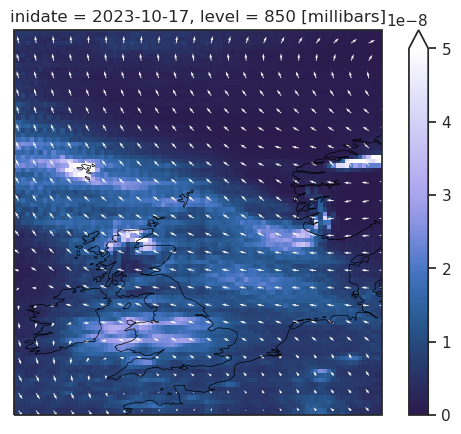

In [21]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(uk, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)

# Plot scalar advection
adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time']).plot(vmin=0, vmax=5e-8, 
                                                                                               cmap=cm.devon, 
                                                                                               ax=ax, 
                                                                                               transform=ccrs.PlateCarree())

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
          u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
          v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
          transform=ccrs.PlateCarree(), scale=20, color='white')